In [1]:
import metnum
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
#Estética de los gráficos
sns.set(color_codes=True)

from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, cohen_kappa_score

In [2]:
percentageTrain = 90
percentageTest = 10

df = pd.read_csv("../data/train.csv")

offset      = (df.shape[0]*percentageTrain)//100
offset_test = (df.shape[0]*percentageTest)//100

df = pd.concat([df[:offset], df[df.shape[0]-offset_test:]])

In [3]:
X = df[df.columns[1:]].values
y = df["label"].values.reshape(-1, 1)

X.shape, y.shape

((42000, 784), (42000, 1))

# KFold en KNN

In [4]:
%%time

shuffleData = True
seed = 1
results = []
for K in range(5, 11):
    kfold = KFold(K, shuffleData, seed)

    knn = metnum.KNNClassifier(100)

    Ki = 0
    for train, test in kfold.split(df):

        X_train = X[train]
        y_train = y[train]

        X_test = X[test]
        y_test = y[test]

        knn.fit(X_train, y_train)
        knn.predict(X_test) #Predict para cachear resultados

        for k in range(1, 51):
            y_predict = knn.predictWithK(k)
            acc = accuracy_score(y_test, y_predict)
            kappa = cohen_kappa_score(y_test, y_predict)
            results.append({'K': K, 'Ki': Ki, 'k': k, 'acc': acc, 'kappa': kappa})
        Ki += 1

CPU times: user 3h 44min 44s, sys: 1min 29s, total: 3h 46min 13s
Wall time: 3h 45min 18s


In [5]:
kfoldDf = pd.DataFrame(results, columns=['K', 'Ki', 'k', 'acc', 'kappa'])
#kfoldDf.to_csv('kfold-knn-90.csv')

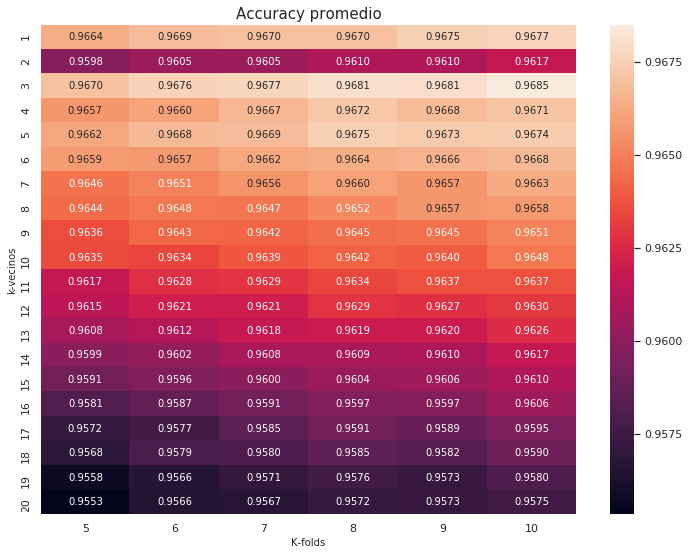

In [108]:
kfoldMean = kfoldDf.groupby(['K', 'k']).mean().reset_index()
kfoldMean = kfoldMean[kfoldMean['k']<=20]
kfoldMean = kfoldMean.pivot("k", "K", "acc")

plt.figure(figsize=(12, 9))

ax = sns.heatmap(kfoldMean, annot=True, fmt='.4f')

plt.title('Accuracy promedio', fontsize = 15)
plt.xlabel('K-folds', fontsize = 10)
plt.ylabel('k-vecinos', fontsize = 10)

#Fix feo para los bordes cortados
b, t = plt.ylim()
b += 0.5
t -= 0.5
plt.ylim(b, t)

plt.show()

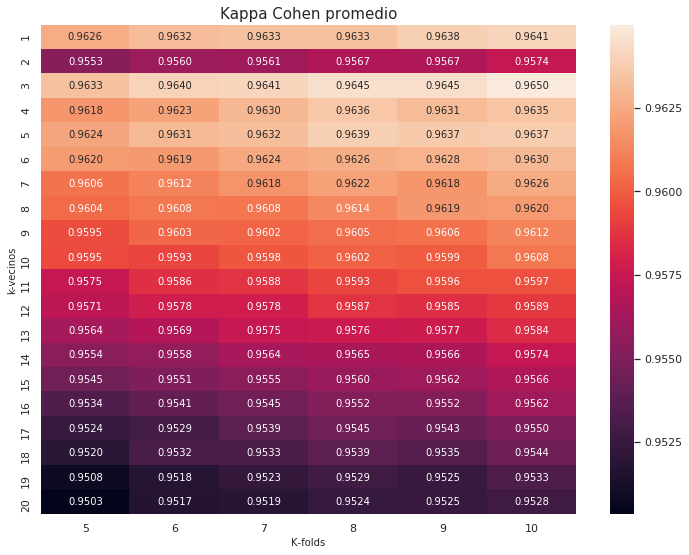

In [109]:
kfoldMean = kfoldDf.groupby(['K', 'k']).mean().reset_index()
kfoldMean = kfoldMean[kfoldMean['k']<=20]
kfoldMean = kfoldMean.pivot("k", "K", "kappa")

plt.figure(figsize=(12, 9))

ax = sns.heatmap(kfoldMean, annot=True, fmt='.4f')

plt.title('Kappa Cohen promedio', fontsize = 15)
plt.xlabel('K-folds', fontsize = 10)
plt.ylabel('k-vecinos', fontsize = 10)

#Fix feo para los bordes cortados
b, t = plt.ylim()
b += 0.5
t -= 0.5
plt.ylim(b, t)

plt.show()

# KFold KNN+PCA

In [7]:
%%time

shuffleData = True
seed = 1
K = 10
kfold = KFold(K, shuffleData, seed)

knn = metnum.KNNClassifier(100)

Ki = 0
results = []
for train, test in kfold.split(df):

    X_train = X[train]
    y_train = y[train]

    X_test = X[test]
    y_test = y[test]

    pca = metnum.PCA(50)
    pca.fit(X_train)
    print(f"PCA {Ki}")
    for alpha in range(10, 51):

        X_train_pca = pca.transformBeta(X_train, alpha)
        X_test_pca = pca.transformBeta(X_test, alpha)
        
        knn.fit(X_train_pca, y_train)
        knn.predict(X_test_pca) #Predict para cachear

        for k in range(1, 51):
            y_predict = knn.predictWithK(k)
            acc = accuracy_score(y_test, y_predict)
            kappa = cohen_kappa_score(y_test, y_predict)
            results.append({'K': K, 'Ki': Ki, 'k': k, 'alpha': alpha, 'acc': acc, 'kappa': kappa})
    Ki += 1

PCA 0
PCA 1
PCA 2
PCA 3
PCA 4
PCA 5
PCA 6
PCA 7
PCA 8
PCA 9
CPU times: user 4h 57min 21s, sys: 2min 3s, total: 4h 59min 24s
Wall time: 4h 58min 58s


In [8]:
kfoldPCADf = pd.DataFrame(results)
#kfoldPCADf.to_csv('kfold-pca-90.csv')

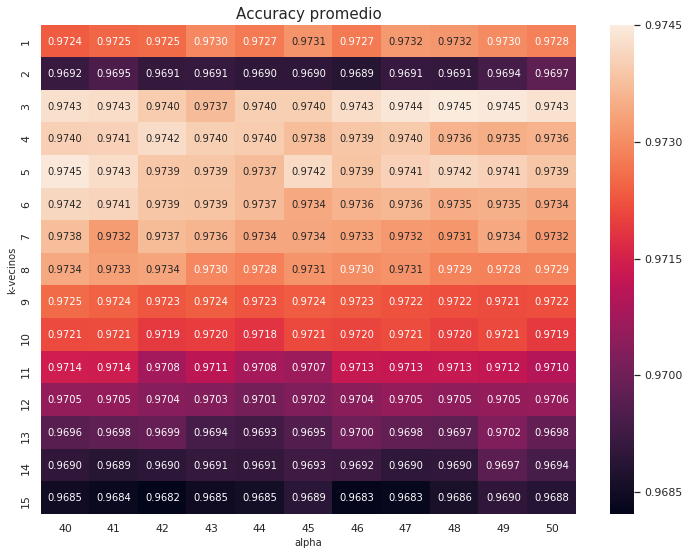

In [110]:
kfoldMean = kfoldPCADf.groupby(['k', 'alpha']).mean().reset_index()
kfoldMean = kfoldMean[kfoldMean['k']<=15]
kfoldMean = kfoldMean[kfoldMean['alpha']>=40]
kfoldMean = kfoldMean[kfoldMean['alpha']<=50]
kfoldMean = kfoldMean.pivot("k", "alpha", "acc")

plt.figure(figsize=(12, 9))

ax = sns.heatmap(kfoldMean, annot=True, fmt='.4f')

plt.title('Accuracy promedio', fontsize = 15)
plt.xlabel('alpha', fontsize = 10)
plt.ylabel('k-vecinos', fontsize = 10)

#Fix feo para los bordes cortados
b, t = plt.ylim()
b += 0.5
t -= 0.5
plt.ylim(b, t)

plt.show()

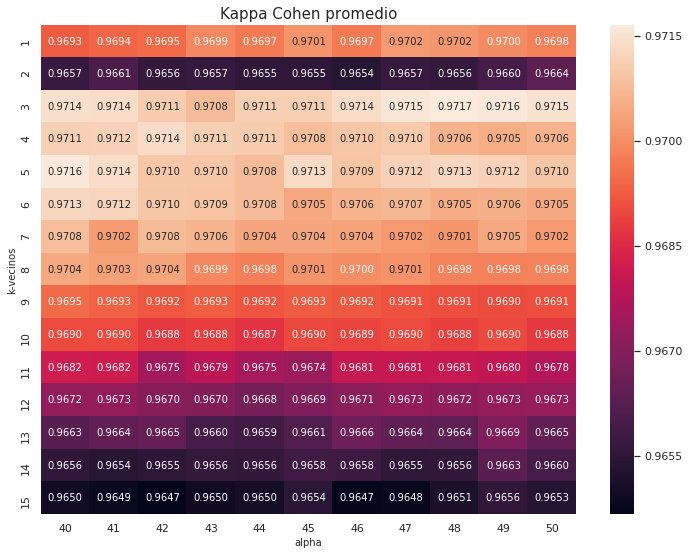

In [106]:
kfoldMean = kfoldPCADf.groupby(['k', 'alpha']).mean().reset_index()
kfoldMean = kfoldMean[kfoldMean['k']<=15]
kfoldMean = kfoldMean[kfoldMean['alpha']>=40]
kfoldMean = kfoldMean[kfoldMean['alpha']<=50]
kfoldMean = kfoldMean.pivot("k", "alpha", "kappa")

plt.figure(figsize=(12, 9))

ax = sns.heatmap(kfoldMean, annot=True, fmt='.4f')

plt.title('Kappa Cohen promedio', fontsize = 15)
plt.xlabel('alpha', fontsize = 10)
plt.ylabel('k-vecinos', fontsize = 10)

#Fix feo para los bordes cortados
b, t = plt.ylim()
b += 0.5
t -= 0.5
plt.ylim(b, t)

plt.show()